### Library

In [4]:
!pip install gym
!pip install pygame

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 21.8 MB 1.6 MB/s 


In [5]:
import gym
from gym.spaces import Discrete as DiscreteSpace
import pandas as pd
import matplotlib.pyplot as plt
import random
import torch
from collections import deque, namedtuple
import numpy as np
import torch.nn.functional as F
from torch.autograd import Variable
from torch import multiprocessing as mp


### Replay Memory

In [6]:
Transition = namedtuple('Transition', ('states', 'actions', 'rewards', 'next_states',
                                       'done', 'exploration_statistics'))

class ReplayBuffer:
    """
    Replay buffer for the agents.
    """
    def __init__(self):
        self.episodes = deque([[]], maxlen=REPLAY_BUFFER_SIZE)

    def add(self, transition):
        """
        Add a new transition to the buffer.
        Parameters
        ----------
        transition : Transition
            The transition to add.
        """
        if self.episodes[-1] and self.episodes[-1][-1].done[0, 0]:
            self.episodes.append([])
        self.episodes[-1].append(transition)

    def sample(self, batch_size, window_length=float('inf')):
        """
        Sample a batch of trajectories from the buffer. If they are of unequal length
        (which is likely), the trajectories will be padded with zero-reward transitions.
        Parameters
        ----------
        batch_size : int
            The batch size of the sample.
        window_length : int, optional
            The window length.
        Returns
        -------
        list of Transition's
            A batched sampled trajectory.
        """
        batched_trajectory = []
        trajectory_indices = random.choices(range(len(self.episodes)-1), k=min(batch_size, len(self.episodes)-1))
        trajectories = []
        for trajectory in [self.episodes[index] for index in trajectory_indices]:
            start = random.choices(range(len(trajectory)), k=1)[0]
            trajectories.append(trajectory[start:start + window_length])
        smallest_trajectory_length = min([len(trajectory) for trajectory in trajectories]) if trajectories else 0
        for index in range(len(trajectories)):
            trajectories[index] = trajectories[index][-smallest_trajectory_length:]
        for transitions in zip(*trajectories):
            batched_transition = Transition(*[torch.cat(data, dim=0) for data in zip(*transitions)])
            batched_trajectory.append(batched_transition)
        return batched_trajectory

    @staticmethod
    def extend(transition):
        """
        Generate a new zero-reward transition to extend a trajectory.
        Parameters
        ----------
        transition : Transition
            A terminal transition which will become the new transition's previous
            transition in the trajectory.
        Returns
        -------
        Transition
            The new transition that can be used to extend a trajectory.
        """
        if not transition.done[0, 0]:
            raise ValueError("Can only extend a terminal transition.")
        exploration_statistics = torch.ones(transition.exploration_statistics.size()) \
                                 / transition.exploration_statistics.size(-1)
        transition = Transition(states=transition.next_states,
                                actions=transition.actions,
                                rewards=torch.FloatTensor([[0.]]),
                                next_states=transition.next_states,
                                done=transition.done,
                                exploration_statistics=exploration_statistics)
        return transition

### Ornstein Uhlenbeck

In [7]:
class OrnsteinUhlenbeckProcess:
    def __init__(self, theta, mu, sigma, time_scale=1e-1,
                 size=1, initial_value=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.time_scale = time_scale
        self.size = size
        self.initial_value = initial_value if initial_value is not None else np.zeros(size)
        self.previous_value = self.initial_value

    def sample(self):
        value = self.previous_value
        value += self.theta * (self.mu - self.previous_value) * self.time_scale
        value += self.sigma * np.sqrt(self.time_scale) * np.random.normal(size=self.size)
        return value

    def reset(self):
        self.previous_value = self.initial_value

    def sampling_parameters(self):
        mean = self.previous_value + self.theta * (self.mu - self.previous_value) * self.time_scale
        sd = self.sigma * np.sqrt(self.time_scale) * np.ones((self.size,))
        return mean, sd

### Actor critic

In [8]:
class ActorCritic(torch.nn.Module):
    """
    Actor-critic network used in A3C and ACER.
    """
    def __init__(self):
        super().__init__()

    def forward(self, *input):
        raise NotImplementedError

    def copy_parameters_from(self, source, decay=0.):
        """
        Copy the parameters from another network.
        Parameters
        ----------
        source : ActorCritic
            The network from which to copy the parameters.
        decay : float, optional
            How much decay should be applied? Default is 0., which means the parameters
            are completely copied.
        """
        for parameter, source_parameter in zip(self.parameters(), source.parameters()):
            parameter.data.copy_(decay * parameter.data + (1 - decay) * source_parameter.data)

    def copy_gradients_from(self, source):
        """
        Copy the gradients from another network.
        Parameters
        ----------
        source : ActorCritic
            The network from which to copy the gradients.
        """
        for parameter, source_parameter in zip(self.parameters(), source.parameters()):
            parameter._grad = source_parameter.grad

##### Discrete Actor critic

In [9]:

class DiscreteActorCritic(ActorCritic):
    """
    Discrete actor-critic network used in A3C and ACER.
    """
    def __init__(self):
        super().__init__()
        self.input_layer = torch.nn.Linear(STATE_SPACE_DIM, 32)
        self.hidden_layer = torch.nn.Linear(32, 32)
        self.action_layer = torch.nn.Linear(32, ACTION_SPACE_DIM)
        self.action_value_layer = torch.nn.Linear(32, ACTION_SPACE_DIM)

    def forward(self, states):
        """
        Compute a forward pass in the network.
        Parameters
        ----------
        states : torch.Tensor
            The states for which the action probabilities and the action-values must be computed.
        Returns
        -------
        action_probabilities : torch.Tensor
            The action probabilities of the policy according to the actor.
        action_probabilities : torch.Tensor
            The action-values of the policy according to the critic.
        """
        hidden = F.relu(self.input_layer(states))
        hidden = F.relu(self.hidden_layer(hidden))
        action_probabilities = F.softmax(self.action_layer(hidden), dim=-1)
        action_values = self.action_value_layer(hidden)
        return action_probabilities, action_values

### Brain

In [10]:

class Brain:
    """
    A centralized brain for the agents.
    """
    def __init__(self):
        self.actor_critic = None
        self.average_actor_critic = None
        self.train_logs = mp.Queue()

class DiscreteBrain(Brain):
    def __init__(self):
        super().__init__()
        self.actor_critic = DiscreteActorCritic()
        self.actor_critic.share_memory()
        self.average_actor_critic = DiscreteActorCritic()
        self.average_actor_critic.share_memory()
        self.average_actor_critic.copy_parameters_from(self.actor_critic)

### Agent

In [11]:
class Agent:
    """
    Agent that learns an optimal policy using ACER.
    Parameters
    ----------
    brain : brain.Brain
        The brain to update.
    render : boolean, optional
        Should the agent render its actions in the on-policy phase?
    verbose : boolean, optional
        Should the agent print progress to the console?
    """
    def __init__(self, brain, render=False, verbose=False):
        self.env = gym.make(ENVIRONMENT_NAME, render_mode="rgb_array")
        self.env.reset()
        self.render = render
        self.verbose = verbose
        self.buffer = ReplayBuffer()
        self.brain = brain
        self.optimizer = torch.optim.Adam(brain.actor_critic.parameters(),
                                          lr=LEARNING_RATE)

#### Discrete Agent

In [12]:
class DiscreteAgent(Agent):
    def __init__(self, brain, render=True, verbose=True):
        super().__init__(brain, render, verbose)
        
    def run(self):
        """
        Run the agent for several episodes.
        """
        for episode in range(MAX_EPISODES):
            episode_rewards = 0
            episode_length = 0
            end_of_episode = False
#             if self.verbose:
#                 print("Episode #{}".format(episode), end="")
            while not end_of_episode:
                trajectory = self.explore(self.brain.actor_critic) 
                self.learning_iteration(trajectory)
                end_of_episode = trajectory[-1].done[0, 0]
                episode_rewards += sum([transition.rewards[0, 0] for transition in trajectory])
                episode_length += len(trajectory)
                for trajectory_count in range(np.random.poisson(REPLAY_RATIO)):
                    trajectory = self.buffer.sample(OFF_POLICY_MINIBATCH_SIZE, MAX_REPLAY_SIZE)
                    if trajectory:
                        self.learning_iteration(trajectory)
                        episode_length += len(trajectory)

#             if self.verbose:
#                 print(", episode rewards {} - episode length {}".format(episode_rewards,episode_length))
            self.brain.train_logs.put([episode_rewards.numpy(),episode_length,episode])

             
    def learning_iteration(self, trajectory):
        """
        Conduct a single discrete learning iteration. Analogue of Algorithm 2 in the paper.
        """
        actor_critic = DiscreteActorCritic()
        actor_critic.copy_parameters_from(self.brain.actor_critic)

        _, _, _, next_states, _, _ = trajectory[-1]
        action_probabilities, action_values = actor_critic(Variable(next_states))
        retrace_action_value = (action_probabilities * action_values).data.sum(-1).unsqueeze(-1)

        for states, actions, rewards, _, done, exploration_probabilities in reversed(trajectory):
            action_probabilities, action_values = actor_critic(Variable(states))
            average_action_probabilities, _ = self.brain.average_actor_critic(Variable(states))
            value = (action_probabilities * action_values).data.sum(-1).unsqueeze(-1) * (1. - done)
            action_indices = Variable(actions.long())

            importance_weights = action_probabilities.data / exploration_probabilities
            
            naive_advantage = action_values.gather(-1, action_indices).data - value
            retrace_action_value = rewards + DISCOUNT_FACTOR * retrace_action_value * (1. - done)
            retrace_advantage = retrace_action_value - value

            # Actor
            # actor_loss = - ACTOR_LOSS_WEIGHT * Variable(
            #     importance_weights.gather(-1, action_indices.data).clamp(max=TRUNCATION_PARAMETER) * retrace_advantage) \
            #     * action_probabilities.gather(-1, action_indices).log()
            # actor_loss = - ACTOR_LOSS_WEIGHT * Variable(
            #                           naive_advantage*action_probabilities.data) * action_probabilities.log()
            actor_loss = - ACTOR_LOSS_WEIGHT * Variable(importance_weights.clamp(min=0.) *
                                      naive_advantage*action_probabilities.data) * action_probabilities.log()
            # bias_correction = - ACTOR_LOSS_WEIGHT * Variable((1 - TRUNCATION_PARAMETER / importance_weights).clamp(min=0.) *
            #                           naive_advantage * action_probabilities.data) * action_probabilities.log()
            # actor_loss += bias_correction.sum(-1).unsqueeze(-1)
            actor_gradients = torch.autograd.grad(actor_loss.mean(), action_probabilities, retain_graph=True)
            # actor_gradients = self.discrete_trust_region_update(actor_gradients, action_probabilities,
            #                                            Variable(average_action_probabilities.data))
            action_probabilities.backward(actor_gradients, retain_graph=True)

            # Critic
            # critic_loss = (action_values.gather(-1, action_indices) - Variable(retrace_action_value)).pow(2)
            critic_loss = (action_values.gather(-1, action_indices) - Variable(value)).pow(2)
            critic_loss.mean().backward(retain_graph=True)

            # Entropy
            entropy_loss = ENTROPY_REGULARIZATION * (action_probabilities * action_probabilities.log()).sum(-1)
            entropy_loss.mean().backward(retain_graph=True)

            retrace_action_value = importance_weights.gather(-1, action_indices.data).clamp(max=1.) * \
                                   (retrace_action_value - action_values.gather(-1, action_indices).data) + value
        self.brain.actor_critic.copy_gradients_from(actor_critic)
        self.optimizer.step()
        # self.brain.average_actor_critic.copy_parameters_from(self.brain.actor_critic, decay=TRUST_REGION_DECAY)
        self.brain.average_actor_critic.copy_parameters_from(self.brain.actor_critic)
        

    def explore(self, actor_critic):
        """
        Explore an environment by taking a sequence of actions and saving the results in the memory.
        Parameters
        ----------
        actor_critic : ActorCritic
            The actor-critic model to use to explore.
        """
        state = torch.FloatTensor(self.env.env.state)
        trajectory = []
        for step in range(MAX_STEPS_BEFORE_UPDATE):
            action_probabilities, *_ = actor_critic(Variable(state))
            action = action_probabilities.multinomial(1)
            action = action.data
            exploration_statistics = action_probabilities.data.view(1, -1)
            next_state, reward, done, _= self.env.step(action.numpy()[0])
            next_state = torch.from_numpy(next_state).float()
            if self.render:
                self.env.render()
            transition = Transition(states=state.view(1, -1),
                                                  actions=action.view(1, -1),
                                                  rewards=torch.FloatTensor([[reward]]),
                                                  next_states=next_state.view(1, -1),
                                                  done=torch.FloatTensor([[done]]),
                                                  exploration_statistics=exploration_statistics)
            self.buffer.add(transition)
            trajectory.append(transition)
            if done:
                self.env.reset()
                break
            else:
                state = next_state
        return trajectory

    @staticmethod
    def discrete_trust_region_update(actor_gradients, action_probabilities, average_action_probabilities):
        """
        Update the actor gradients so that they satisfy a linearized KL constraint with respect
        to the average actor-critic network. See Section 3.3 of the paper for details.
        Parameters
        ----------
        actor_gradients : tuple of torch.Tensor's
            The original gradients.
        action_probabilities
            The action probabilities according to the current actor-critic network.
        average_action_probabilities
            The action probabilities according to the average actor-critic network.
        Returns
        -------
        tuple of torch.Tensor's
            The updated gradients.
        """
        negative_kullback_leibler = - ((average_action_probabilities.log() - action_probabilities.log())
                                       * average_action_probabilities).sum(-1)
        kullback_leibler_gradients = torch.autograd.grad(negative_kullback_leibler.mean(),
                                                         action_probabilities, retain_graph=True)
        updated_actor_gradients = []
        for actor_gradient, kullback_leibler_gradient in zip(actor_gradients, kullback_leibler_gradients):
            scale = actor_gradient.mul(kullback_leibler_gradient).sum(-1).unsqueeze(-1) - TRUST_REGION_CONSTRAINT
            scale = torch.div(scale, actor_gradient.mul(actor_gradient).sum(-1).unsqueeze(-1)).clamp(min=0.)
            updated_actor_gradients.append(actor_gradient - scale * kullback_leibler_gradient)
        return updated_actor_gradients


### Run agent

In [13]:
def run_agent(shared_brain, render=False, verbose=False):
    """
    Run the agent.
    Parameters
    ----------
    shared_brain : brain.Brain
        The shared brain the agents will use and update.
    render : boolean, optional
        Should the agent render its actions in the on-policy phase?
    verbose : boolean, optional
        Should the agent print progress to the console?
    """
    local_agent = DiscreteAgent(shared_brain, render, verbose)
    local_agent.run()

In [14]:
def test(ENVIRONMENT_NAME="CartPole-v1",model_path="model.pkl",num_episodes=1000):
  
  # Create the environment
  env = gym.make(ENVIRONMENT_NAME)
  
  ## Environment parameters
  action_space = env.action_space
  state_space = env.observation_space
  ACTION_SPACE_DIM = action_space.n
  STATE_SPACE_DIM = state_space.shape[0]


  ## load model here
  model = torch.load(model_path)
  model.eval()

  # Set the number of episodes to run
  num_episodes = 1000

  # Create lists to store the returns for each episode
  returns = []

  # Run the episodes
  for episode in range(num_episodes):
    # Reset the environment at the start of each episode
    state = env.reset()
    
    # Initialize the episode return
    episode_return = 0
    episode_length = 0  
    # Run the episode
    done = False
    while not done:
      # Get the action from the model
      action_prob,_  = model(torch.Tensor(state))
      
      # Step the environment with the action
      next_state, reward, done, _ = env.step(torch.argmax(action_prob).numpy())
      
      # Update the episode return
      episode_return += reward
      episode_length += 1
      # Update the state
      state = next_state
    # Add the episode return to the list of returns
    returns.append([episode_return,episode_length]) 
#     print(episode,episode_return,episode_length)
  return returns

### Init Configuration

In [15]:

ENVIRONMENT_NAME = 'CartPole-v1'
# ENVIRONMENT_NAME = 'MountainCarContinuous-v0'

env = gym.make(ENVIRONMENT_NAME, render_mode="rgb_array")
action_space = env.action_space
state_space = env.observation_space
env.close()
del env

ACTION_SPACE_DIM = action_space.n
CONTROL = 'discrete'
STATE_SPACE_DIM = state_space.shape[0]

# Parameters that work well for CartPole-v0
LEARNING_RATE = 1e-3

### this is hyperparameter
REPLAY_BUFFER_SIZE = 100
REPLAY_RATIO = 4
MAX_EPISODES = 500
OFF_POLICY_MINIBATCH_SIZE = 16
MAX_REPLAY_SIZE = 200


TRUNCATION_PARAMETER = 10
DISCOUNT_FACTOR = 0.99
MAX_STEPS_BEFORE_UPDATE = 20
NUMBER_OF_AGENTS = 2
TRUST_REGION_CONSTRAINT = 1.
TRUST_REGION_DECAY = 0.99
ENTROPY_REGULARIZATION = 1e-3
ACTOR_LOSS_WEIGHT = 0.1

# Not used for discrete agents
ORNSTEIN_UHLENBECK_NOISE_SCALE = None
INITIAL_ORNSTEIN_UHLENBECK_NOISE_RATIO = None
NUMBER_OF_EXPLORATION_EPISODES = None
INITIAL_STANDARD_DEVIATION = None

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


#### Training

In [16]:
!mkdir IS

mkdir: cannot create directory ‘IS’: File exists


In [17]:
for MAX_EPISODES in [100,250,500]:
    for REPLAY_RATIO in [1,2,4,8]:
            for itern in range(10):
#                 try:
                brain = DiscreteBrain()
                local_agent = DiscreteAgent(brain, False,True)
                local_agent.run()

                length = brain.train_logs.qsize()
                out = [brain.train_logs.get_nowait() for _ in range(length)]
                train_result = pd.DataFrame(out,columns=["Expected Reward","Episode length","Episode number"])

                pathName = "IS/" + ENVIRONMENT_NAME + "_" + str(MAX_EPISODES) + "_" + str(REPLAY_RATIO) \
                            + "_" + str(itern) + "_" + "IS_"
                print("############################################################")
                print(pathName)
                ## save logs
                train_result.to_csv( pathName + "train_result.csv",index=None)

                ## save model
                torch.save(brain.actor_critic, pathName + "model.pkl")

                returns = test(ENVIRONMENT_NAME, model_path=  pathName+"model.pkl", num_episodes=1000)

                test_results = pd.DataFrame(returns,columns=["Expected Rewards","Episode Length"])
                test_results.to_csv(pathName+ "test_result.csv",index=None)
#                 except:
#                     print("-------------------------------ERROR ------------------------------------------")

############################################################
IS/CartPole-v1_100_1_0_IS_
############################################################
IS/CartPole-v1_100_1_1_IS_
############################################################
IS/CartPole-v1_100_1_2_IS_
############################################################
IS/CartPole-v1_100_1_3_IS_
############################################################
IS/CartPole-v1_100_1_4_IS_
############################################################
IS/CartPole-v1_100_1_5_IS_
############################################################
IS/CartPole-v1_100_1_6_IS_
############################################################
IS/CartPole-v1_100_1_7_IS_
############################################################
IS/CartPole-v1_100_1_8_IS_
############################################################
IS/CartPole-v1_100_1_9_IS_
############################################################
IS/CartPole-v1_100_2_0_IS_
################################

In [ ]:
250,4,9

5

In [18]:
import glob

In [19]:
out =[]
for file in glob.glob("./IS/*test*.csv"):
    data = pd.read_csv(file)
    out.append(file.split("_")[1:4] + [data["Expected Rewards"].mean(),data['Expected Rewards'].std()])


In [20]:
resdf = pd.DataFrame(out,columns=["Max_episodes","Replay","itern","mean","std"]).groupby(by=["Max_episodes","Replay"],as_index=False).mean()

In [21]:
resdf

,Max_episodes,Replay,mean,std
0,100,1,24.1022,8.802536
1,100,2,19.8883,7.295012
2,100,4,23.2624,10.939580
3,100,8,28.4503,13.384068
4,250,1,24.8722,8.462178
5,250,2,25.0103,11.463606
6,250,4,22.4186,13.110303
7,250,8,14.2407,4.543888
8,500,1,26.6887,11.916351
9,500,2,20.9840,13.809516


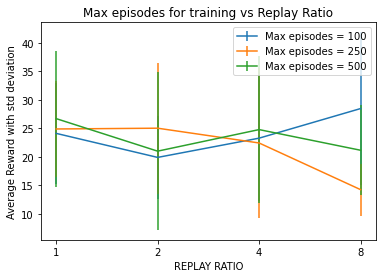

In [22]:
for episode in ["100","250","500"]:
    plt.errorbar(resdf.loc[resdf["Max_episodes"].isin([episode]),"Replay"],
                resdf.loc[resdf["Max_episodes"].isin([episode]),"mean"],
                resdf.loc[resdf["Max_episodes"].isin([episode]),"std"],label="Max episodes = "+ episode)
plt.xlabel("REPLAY RATIO")
plt.ylabel("Average Reward with std deviation")
plt.title("Max episodes for training vs Replay Ratio")
plt.legend()